In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt
from skimage.util import view_as_windows

In [ ]:
# Download the data from FTP
!wget ftp://ftp.nersc.no/pub/ml_course/S3A_OL_2_WFR_20200620T103116_CHL_LABELS.npz

--2021-12-15 11:23:31--  ftp://ftp.nersc.no/reddaml/share/S3A_OL_2_WFR_20200620T103116_CHL_LABELS.npz
           => ‘S3A_OL_2_WFR_20200620T103116_CHL_LABELS.npz.6’
Resolving ftp.nersc.no (ftp.nersc.no)... 158.37.60.245
Connecting to ftp.nersc.no (ftp.nersc.no)|158.37.60.245|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/ml_course ... done.
==> SIZE S3A_OL_2_WFR_20200620T103116_CHL_LABELS.npz ... 8758698
==> PASV ... done.    ==> RETR S3A_OL_2_WFR_20200620T103116_CHL_LABELS.npz ... done.
Length: 8758698 (8.4M) (unauthoritative)

_OL_2_WFR_20200620T  79%[==============>     ]   6.64M  2.22MB/s               

In [3]:
def fill_gaps(array, distance=5):
    """ Fill gaps in input raster

    Parameters
    ----------
    array : 2D numpy.array
        Raster with valid values and with nans
    distance : int
        Minimum size of gap to fill

    Returns
    -------
    array : 2D numpy.array
        Ratser with small gaps filled by nearest neigbour

    """
    dist, indi = distance_transform_edt(
        np.isnan(array),
        return_distances=True,
        return_indices=True)
    gpi = dist <= distance
    r,c = indi[:,gpi]
    array[gpi] = array[r,c]
    return array

def normalize_chl(chl, percentiles=(1,99)):
    """ Normalize input chlorophyll values """
    # Mask zero values with NaN
    chl[chl == 0] = np.nan
    # Apply log10 tranform to input values to match normal distribution
    chl = np.log10(chl)
    # Replace small gaps with nearest neigbour values
    chl = fill_gaps(chl, 2)
    # Compute min/max values
    chl_lims = np.nanpercentile(chl, percentiles)
    print(chl_lims)
    # replace values outside range with min/max
    chl[chl < chl_lims[0]] = chl_lims[0]
    chl[chl > chl_lims[1]] = chl_lims[1]
    
    return chl

In [4]:
# load arrays into Python
dataset = np.load('S3A_OL_2_WFR_20200620T103116_CHL_LABELS.npz')
chl = dataset['chl'][:, ::2]
lbl = dataset['label'][:, ::2]
print(chl.shape, lbl.dtype, lbl.max())

chl = normalize_chl(chl)

(4091, 4050) float32 1.0
[-0.50393701  0.91338581]


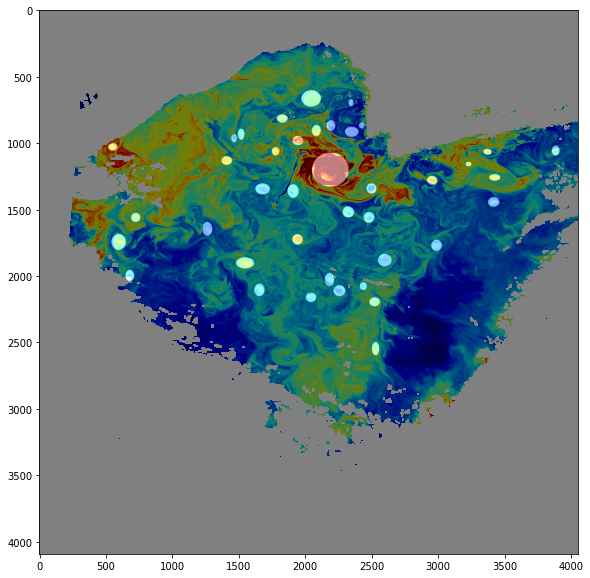

In [5]:
# plot maps of input chl and labels of eddies
plt.figure(figsize=(10,10))
plt.imshow(chl, cmap='jet')
plt.imshow(lbl, cmap='gray', alpha=0.5)
plt.show()

Shape of valid samples  (14670, 50, 50)
Shape of input/output data  (14670, 50, 50, 1) (14670, 50, 50, 1)
No-eddie pixels:  35200318 Eddie pixels  1474682


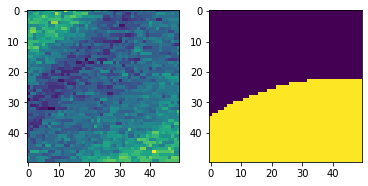

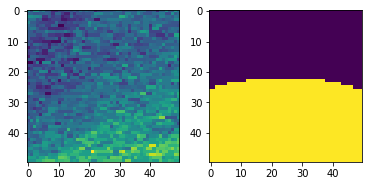

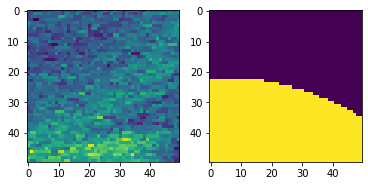

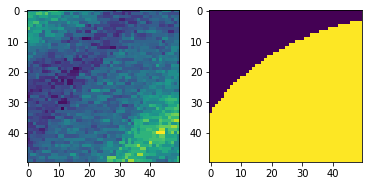

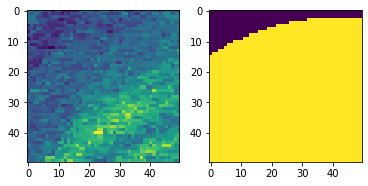

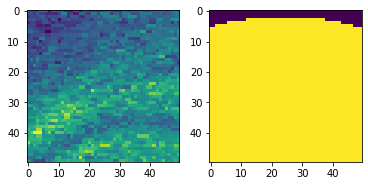

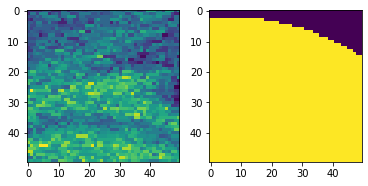

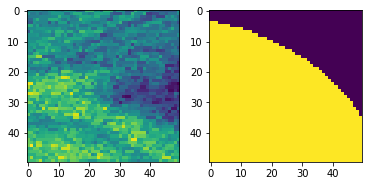

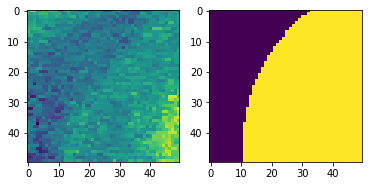

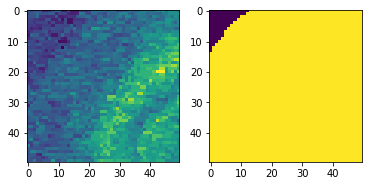

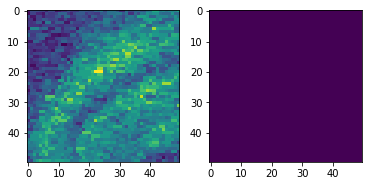

In [6]:
# Example split of the input image into small patches

ws = 50#128 # size of patch
stp = 20#32 # step, at which the patches are sampled
chl_w = view_as_windows(chl, ws, stp)
lbl_w = view_as_windows(lbl, ws, stp)

# reshape from (N_row_patches x N_col_patches x Patch_height x Patch_width)
# into (N_patches x Patch_height x Patch_width)
wshape = chl_w.shape
chl_w = chl_w.reshape(wshape[0]*wshape[1], wshape[2], wshape[3])
lbl_w = lbl_w.reshape(wshape[0]*wshape[1], wshape[2], wshape[3])

# Find valid patches (without NaN)
valid = np.where(np.isfinite(np.min(chl_w, axis=(1,2))))[0]
print('Shape of valid samples ', lbl_w[valid].shape)

# Subsample only valid patches and reshape into 
# N_samples x Height x Width x 1
x = chl_w[valid]
y = lbl_w[valid]
x.shape += (1,)
y.shape += (1,)
print('Shape of input/output data ', x.shape, y.shape)
print('No-eddie pixels: ', np.where(y == 0)[0].size, 'Eddie pixels ', np.where(y == 1)[0].size)

# Plot few patches with large labels
max_plots = 10
k = 0
for x1, y1 in zip(x,y):
    if y1.sum() > 1000:
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(x1[:,:,0])
        ax[1].imshow(y1[:,:,0])
        plt.show()
        k += 1
        if k > max_plots:
            break


In [7]:
#chl_w = view_as_windows(chl, ws, stp)
#lbl_w = view_as_windows(lbl, ws, stp)

# reshape from (N_row_patches x N_col_patches x Patch_height x Patch_width)
# into (N_patches x Patch_height x Patch_width)
#wshape = chl_w.shape
#chl_w = chl_w.reshape(wshape[0]*wshape[1], wshape[2], wshape[3])
#lbl_w = lbl_w.reshape(wshape[0]*wshape[1], wshape[2], wshape[3])

# Subsample only valid patches and reshape into 
# N_samples x Height x Width x 1
#x = chl_w[valid]
#y = lbl_w[valid]
#x.shape += (1,)
#y.shape += (1,)
print('original: '+str(chl.shape))
print('reshaped windows before invalid removed: ',str(chl_w.shape))
print('Shape of input/output data ', x.shape, y.shape)
print('No-eddie pixels: ', np.where(y == 0)[0].size, 'Eddie pixels ', np.where(y == 1)[0].size)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,
                                     Flatten,
                                     Dropout,
                                     BatchNormalization, 
                                     Conv2D, 
                                     MaxPooling2D)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

#import autokeras as ak

## We have split it into rolling windows. 
## Each window can be used to identify if any eddy or not
xx = np.zeros([np.shape(y)[0],np.shape(y)[1],np.shape(y)[2],1])
xx[:,:,:,0] = np.squeeze(x*1)
#xx[:,:,:,1] = np.squeeze(x*1)
yy = y.mean(axis=(1,2,3))
yy[yy>0] = 1
yy[yy<=0] = 0
print(xx.shape)
print(yy.shape)

# Create a CNN with an simplest configuration
# Sequential type NN: one input + hidden layers + one output
m = Sequential()
# Convolutional layer. Input: SAR in HH and HV polarisations
m.add(Conv2D(
    filters=5, 
    kernel_size=(3,3), 
    strides=(1,1), 
    padding='valid', 
    activation='relu', 
    input_shape=x.shape[1:]))
# Reshape from 2D to 1D
m.add(Flatten())
# Output neuron with SIC
m.add(Dense(units=1, kernel_initializer='random_normal'))

# Plot summary
m.summary()

# Compile model and set how to compute LOSS and how to Optimize
m.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Train model in 20 epochs with batch_size = 100. 20% of data go to validation
h1 = m.fit(xx, yy, batch_size=100, epochs=20, validation_split=0.1)

   



original: (4091, 4050)
reshaped windows before invalid removed:  (40803, 50, 50)
Shape of input/output data  (14670, 50, 50, 1) (14670, 50, 50, 1)
No-eddie pixels:  35200318 Eddie pixels  1474682
(14670, 50, 50, 1)
(14670,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 5)         50        
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 1)                 11521     
                                                                 
Total params: 11,571
Trainable params: 11,571
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
133/133 [==============================] - 14s 103ms/step - loss: 0.1073 - val_lo

LOSS 0.05780988186597824 0.01990721933543682


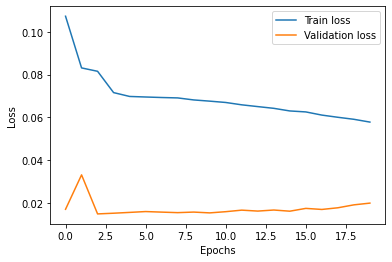

In [8]:
# Plot how eeror was decreasing with training
plt.figure()
plt.plot(h1.history['loss'], label='Train loss')
plt.plot(h1.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
print('LOSS', h1.history['loss'][-1], h1.history['val_loss'][-1]) 




(40803, 50, 50)
(40803, 1)


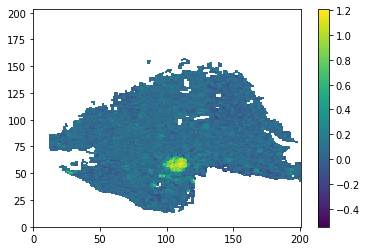

In [9]:
chl_w_orig = view_as_windows(chl, ws, stp)
lbl_w_orig = view_as_windows(lbl, ws, stp)

x_all = chl_w*1
print(x_all.shape)
y_all = m.predict(x_all)
print(y_all.shape)
y_all.shape = chl_w_orig.shape[:2]

plt.figure()
plt.pcolormesh(y_all)
plt.colorbar()


50
20
4091
4050
(203, 201)
(203, 201)


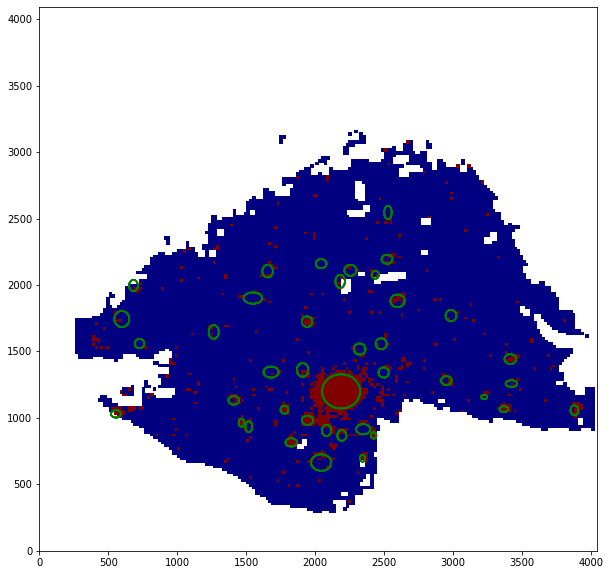

accuracy


In [10]:
print(ws)
print(stp)
th = 0.2


y_bin = y_all*1
y_bin[y_bin<=th] = 0
y_bin[y_bin>th] = 1

leny,lenx = np.shape(chl)
print(leny)
print(lenx)
xbig,ybig = np.meshgrid(np.arange(ws/2,lenx-ws/2+1,stp),np.arange(ws/2,leny-ws/2+1,stp))
print(xbig.shape)
print(y_bin.shape)
plt.figure(figsize=(10,10))
plt.pcolormesh(xbig,ybig,y_bin, cmap='jet')
plt.contour(lbl,colors='g')
#plt.imshow(lbl, cmap='gray', alpha=0.5)
plt.show()


rx = np.arange(ws/2,lenx-ws/2+1,stp).astype(int)
ry = np.arange(ws/2,leny-ws/2+1,stp).astype(int)



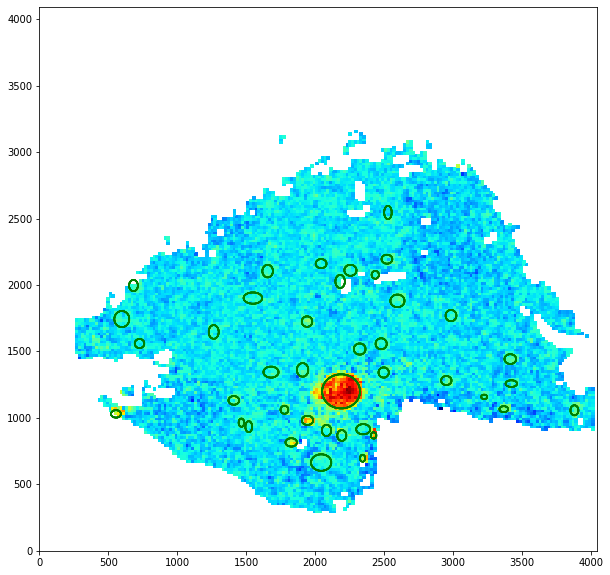

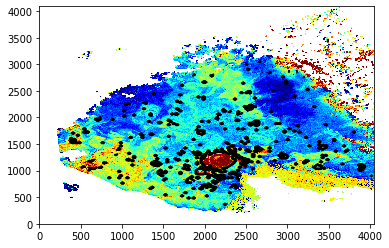

In [11]:
plt.figure(figsize=(10,10))
plt.pcolormesh(xbig,ybig,y_all, cmap='jet')
plt.contour(lbl,colors='g')
#plt.imshow(lbl, cmap='gray', alpha=0.5)
plt.show()

plt.figure()
plt.pcolormesh(chl,cmap='jet')
plt.contour(xbig,ybig,y_bin,colors='k')
plt.show()

In [126]:
import sys
sys.exit()


(array([ 215,  215,  216, ..., 4074, 4074, 4075]), array([2386, 2387, 2385, ..., 3630, 3631, 3630]))


ValueError: ignored

(124, 123)
16384
(4091, 4050)


(4754, 128, 128, 1)
(4754, 128, 128, 1)
(4091, 4050)
(3272, 4050) (819, 4050) (3272, 4050) (819, 4050)


ValueError: ignored

(4754, 128, 128, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 5)       50        
                                                                 
 flatten (Flatten)           (None, 79380)             0         
                                                                 
 dense (Dense)               (None, 1)                 79381     
                                                                 
Total params: 79,431
Trainable params: 79,431
Non-trainable params: 0
_________________________________________________________________
(4754, 128, 128, 1)
(4754, 128, 128, 1)
Epoch 1/20
39/39 [==============================] - 14s 330ms/step - loss: 0.3495 - val_loss: 0.0377
Epoch 2/20
39/39 [==============================] - 13s 327ms/step - loss: 0.0511 - val_loss: 0.0273
Epoch 3/20
39/39 [==============================] - 13

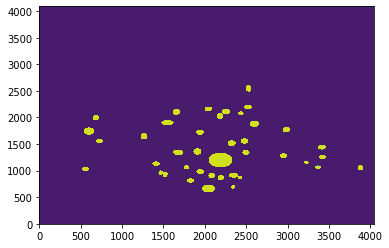

LOSS 0.009423541836440563 0.0042387996800243855


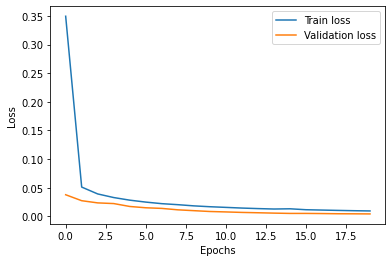

(4754, 128, 128, 1)
(4754, 1)


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


(7340442, 1) (7340442,)
(5872353, 1) (1468089, 1) (5872353,) (1468089,)
0.9669216239614901


(2, 7340442)
(7340442, 2)
(5872353, 2) (1468089, 2) (5872353,) (1468089,)


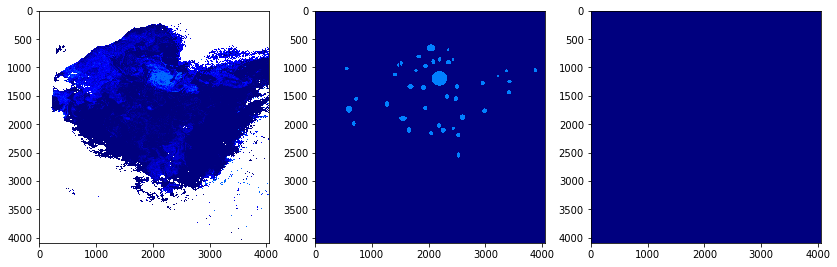

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


0.0
